In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
import re
import lfrData

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [143]:
G_lfr=nx.Graph()
data,labels=lfrData.load_data(0.5)

for index,item in enumerate(labels):
    G_lfr.add_node(index+1,value=item)
for item in data:
    G_lfr.add_edge(*item)
B_lfr = nx.modularity_matrix(G_lfr)

In [144]:
c_attributes = nx.get_node_attributes(G_lfr,'value')
print(c_attributes)

{1: 1, 2: 4, 3: 4, 4: 4, 5: 1, 6: 1, 7: 4, 8: 1, 9: 1, 10: 2, 11: 1, 12: 2, 13: 2, 14: 3, 15: 2, 16: 2, 17: 2, 18: 2, 19: 1, 20: 4, 21: 4, 22: 3, 23: 1, 24: 1, 25: 3, 26: 3, 27: 4, 28: 1, 29: 2, 30: 3, 31: 4, 32: 2, 33: 3, 34: 1, 35: 3, 36: 1, 37: 4, 38: 3, 39: 4, 40: 1, 41: 3, 42: 2, 43: 1, 44: 4, 45: 4, 46: 2, 47: 4, 48: 2, 49: 3, 50: 2, 51: 4, 52: 2, 53: 3, 54: 3, 55: 2, 56: 2, 57: 4, 58: 4, 59: 1, 60: 1, 61: 3, 62: 2, 63: 3, 64: 3, 65: 3, 66: 4, 67: 1, 68: 4, 69: 2, 70: 1, 71: 1, 72: 1, 73: 3, 74: 3, 75: 2, 76: 2, 77: 3, 78: 3, 79: 1, 80: 3, 81: 4, 82: 3, 83: 3, 84: 3, 85: 4, 86: 4, 87: 1, 88: 4, 89: 2, 90: 4, 91: 1, 92: 4, 93: 4, 94: 3, 95: 4, 96: 2, 97: 4, 98: 3, 99: 2, 100: 3, 101: 1, 102: 1, 103: 1, 104: 2, 105: 1, 106: 1, 107: 3, 108: 2, 109: 1, 110: 2, 111: 2, 112: 4, 113: 1, 114: 3, 115: 3, 116: 4, 117: 3, 118: 3, 119: 2, 120: 2, 121: 4, 122: 2, 123: 1, 124: 2, 125: 4, 126: 4, 127: 1, 128: 2}


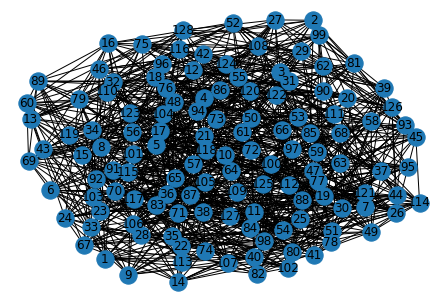

In [145]:
nx.draw(G_lfr,with_labels=True)

In [146]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [147]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        # activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.1)(activation)
        code = self.encoder_output_layer(activation)
        # code = torch.tanh(code)
        # code = nn.Dropout(p=0.1)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        # activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.1)(activation)
        activation = self.decoder_output_layer(activation)
        # reconstructed = torch.tanh(activation)
        return encoder,activation

In [148]:
learning_rate = 1e-3

In [149]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=64,in_layers=128)
model2=AE(hidden_layers=32,in_layers=64)
model3=AE(hidden_layers=16,in_layers=32)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=128, out_features=64, bias=True)
  (encoder_output_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_output_layer): Linear(in_features=64, out_features=128, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=64, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)


In [150]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

epoch : 1/1000, recon loss = 0.11912653
epoch : 2/1000, recon loss = 0.11706640
epoch : 3/1000, recon loss = 0.11522167
epoch : 4/1000, recon loss = 0.11355606
epoch : 5/1000, recon loss = 0.11203677
epoch : 6/1000, recon loss = 0.11063665
epoch : 7/1000, recon loss = 0.10933410
epoch : 8/1000, recon loss = 0.10811183
epoch : 9/1000, recon loss = 0.10695600
epoch : 10/1000, recon loss = 0.10585556
epoch : 11/1000, recon loss = 0.10480159
epoch : 12/1000, recon loss = 0.10378685
epoch : 13/1000, recon loss = 0.10280524
epoch : 14/1000, recon loss = 0.10185143
epoch : 15/1000, recon loss = 0.10092052
epoch : 16/1000, recon loss = 0.10000780
epoch : 17/1000, recon loss = 0.09910866
epoch : 18/1000, recon loss = 0.09821856
epoch : 19/1000, recon loss = 0.09733322
epoch : 20/1000, recon loss = 0.09644880
epoch : 21/1000, recon loss = 0.09556219
epoch : 22/1000, recon loss = 0.09467114
epoch : 23/1000, recon loss = 0.09377436
epoch : 24/1000, recon loss = 0.09287142
epoch : 25/1000, recon lo

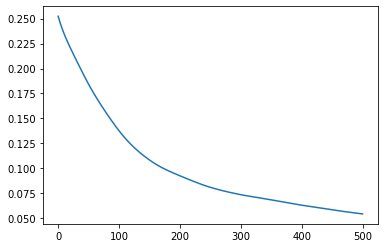

In [151]:
B_lfr=np.asarray(B_lfr,dtype=np.float64)
inputs=torch.from_numpy(B_lfr)
targets=torch.from_numpy(B_lfr)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist1=train_model(1000,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist2=train_model(800,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
plt.plot(hist)
print(encoder.detach().shape)
# AE 3 training
# encoder,hist=train_model(200,train_dl,model3,optimizer3)
# train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder.detach().shape)

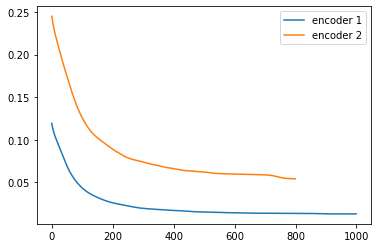

In [152]:
plt.plot(hist1,label='encoder 1')
plt.plot(hist2,label='encoder 2')
plt.legend()
plt.show()

In [153]:
B_lfr_X=encoder.detach().numpy()

In [154]:
print(type(B_lfr_X),B_lfr_X)

<class 'numpy.ndarray'> [[ 0.27130696  0.79247123 -0.7256856  ...  0.73666054 -1.3798478
   0.46749434]
 [-0.57900995  0.41551283 -0.09301732 ... -0.7352115   0.24203987
  -0.06487082]
 [-1.102608    1.6303943   0.0205771  ... -0.40247107 -0.12893865
   0.73574466]
 ...
 [-0.6424843   0.8109641   1.3983498  ... -0.47281373 -0.5682565
   0.45936695]
 [-0.5654329   0.13467218 -0.2933324  ... -0.4207608  -0.2713104
   0.9787449 ]
 [-1.0840685   0.07879702  0.67805827 ... -0.27212662 -0.36700547
  -0.46426693]]


In [157]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=554)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_

c_groups=[]
c_attributes = nx.get_node_attributes(G_lfr,'value')
for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[2 1 1 3 0 2 2 2 2 0 0 1 0 2 2 0 1 1 2 1 3 0 0 2 2 1 3 2 1 3 0 1 2 2 2 0 1
 3 3 2 0 1 2 3 3 0 1 0 2 0 3 1 1 2 1 0 1 1 0 2 0 1 3 2 3 3 3 2 0 0 2 0 3 2
 0 1 0 1 0 3 3 3 3 3 3 1 0 3 0 2 2 1 3 1 3 0 2 1 1 2 2 2 2 2 2 3 2 1 2 1 1
 3 2 3 2 3 2 1 0 0 2 2 0 1 3 3 2 1]
[1 4 4 4 1 1 4 1 1 2 1 2 2 3 2 2 2 2 1 4 4 3 1 1 3 3 4 1 2 3 4 2 3 1 3 1 4
 3 4 1 3 2 1 4 4 2 4 2 3 2 4 2 3 3 2 2 4 4 1 1 3 2 3 3 3 4 1 4 2 1 1 1 3 3
 2 2 3 3 1 3 4 3 3 3 4 4 1 4 2 4 1 4 4 3 4 2 4 3 2 3 1 1 1 2 1 1 3 2 1 2 2
 4 1 3 3 4 3 3 2 2 4 2 1 2 4 4 1 2]


0.24290808358042076

In [156]:
max=0
index_max=0
for value in range(1,1000):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_lfr_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_lfr,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.1723148970154139
Epoch:2 1 0.1723148970154139
Epoch:3 1 0.1723148970154139
Epoch:4 1 0.1723148970154139
Epoch:5 1 0.1723148970154139
Epoch:6 1 0.1723148970154139
Epoch:7 1 0.1723148970154139
Epoch:8 8 0.19010293968974634
Epoch:9 8 0.19010293968974634
Epoch:10 8 0.19010293968974634
Epoch:11 8 0.19010293968974634
Epoch:12 8 0.19010293968974634
Epoch:13 8 0.19010293968974634
Epoch:14 8 0.19010293968974634
Epoch:15 8 0.19010293968974634
Epoch:16 8 0.19010293968974634
Epoch:17 8 0.19010293968974634
Epoch:18 8 0.19010293968974634
Epoch:19 8 0.19010293968974634
Epoch:20 8 0.19010293968974634
Epoch:21 8 0.19010293968974634
Epoch:22 8 0.19010293968974634
Epoch:23 8 0.19010293968974634
Epoch:24 8 0.19010293968974634
Epoch:25 8 0.19010293968974634
Epoch:26 8 0.19010293968974634
Epoch:27 8 0.19010293968974634
Epoch:28 8 0.19010293968974634
Epoch:29 8 0.19010293968974634
Epoch:30 8 0.19010293968974634
Epoch:31 8 0.19010293968974634
Epoch:32 8 0.19010293968974634
Epoch:33 8 0.19010293968